In [1]:
import numpy as np
import math
import scipy
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
from sympy.physics.wigner import wigner_9j
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def int_or_half_int(x):
    return isinstance(x, int) or abs(round(2*x) - 2*x) == 0

def add_ang_mom(L1, L2):
    #
    # given the values of two different angular momenta, returns an array 
    # of the possible values of their sum L1+L2 = l_tot
    #
    
    if not int_or_half_int(L1) or not int_or_half_int(L2):
        raise Exception("Angular momentum values L1, L2 must be non-negative integers or half integers.", "L1 =", L1, "L2 =", L2)

    l_tot_max = L1 + L2
    if L1 == 0 or L2 == 0:
        return [l_tot_max]

    l_tot_min = abs(L1-L2)
    
    ct = int((l_tot_max - l_tot_min + 1)/ 1)
    l_tot_range = [None] * ct

    l_tot_cur = l_tot_min
    for i in range(ct):
        l_tot_range[i] = l_tot_cur
        l_tot_cur += 1
    
    return l_tot_range

def get_m_range(j):
    #
    # given some angular momentum, returns the m values associated with it
    #

    if not int_or_half_int(j) or j < 0:
        raise Exception("Angular momentum value j must be a non-negative integer or half-integer.")

    if j == 0:
        return [0]

    ct = int(2*j +1)
    m_range = [None] * ct

    m_min = -j
    m_cur = m_min
    for i in range(ct):
        m_range[i] = m_cur
        m_cur += 1
    
    return m_range

def neg_1_pow(x):
    return 1 - 2 * (x % 2)


def delta(x1, x2):
    if x1 == x2:
        return True
    else:
        return False
    
def inverse_cm_to_MHz(E_in_inverse_cm):
    return 29979.2458 * E_in_inverse_cm

We use 'weak' field coupled basis:

$\ket{\Lambda, J, I_1, F_1, I_2, F, M_F}$

Where $F_1 = J + I_1$ and $F = F_1 + I_2$.

Note that NaCs is a $^1\Sigma$ molecule, so $\Lambda = 0$, and $S = 0$. Then, we can express our basis as:

$\ket{N, I_1, F_1, I_2, F, M_F}$

Accounting for the fact that $I_1$ and $I_2$ are constant, our matrix elements are really only evaluated for:

$\ket{N, F_1, F, M_F}$

In [3]:
class Interaction:
    def __init__(self, const, functn):
        # const is some constant associated with the interaction energy
        # funct is a function which evaluates the matrix element <state1|interaction|state2>
        self.const = const
        self.functn = functn
        
    def eval_interaction(self, state1, state2):
        return self.const * self.functn(state1, state2)
        
class State:
    def __init__(self, n, f1, f, mf):
        # n is the rotational quantum number N
        # i1 is the nuclear spim quantum number I1 (we do not store it here as it is redundant)
        # f1 is the sum of N and I1
        # i2 is the nuclear spim quantum number I2 (we do not store it here as it is redundant)
        # f is the sum of F1 and I2
        # mf is the projection of F onto the z axis

        self.n = n
        self.f1 = f1
        self.f = f
        self.mf = mf
        
    def __str__(self):
        # returns a string representation of the physical values for each element within the state
        return "n: " + str(self.n) + ", "+ "f1: " + str(self.f1) + ", "+ "f: " + str(self.f) + ", "+ "mf: " + str(self.mf)
    
    def get_state_vector(self):
        ''' Returns the state vector [self.n, self.f1, self.f, self.mf]'''
        return [self.n, self.f1, self.f, self.mf]

In [4]:
class Molecule:
    
    def __init__(self, Nrange, I1, I2, n_Ch_Itrcns = 1):
        # Nrange is an array holding the rotational quantum number range to consider in H
        # I1 is the nuclear spin of atom one
        # I2 is the nuclear spin of atom two
        #
        # We double each input so that we can work with integer values
        self.Nrange = Nrange
        self.I1 = I1
        self.I2 = I2
        self.states = []
        self.n_Ch_Itrcns = n_Ch_Itrcns
        
        for n in self.Nrange:
            for f1 in add_ang_mom(n, self.I1):
                    for f in add_ang_mom(f1, self.I2):
                            for mf in get_m_range(f):
                                self.states.append(State(n, f1, f, mf))

        self.dim = len(self.states)
        print("H has dim", self.dim)
        
        # array of interaction functions
        self.interactions = []
        self.changing_interactions = []
        
        #Initialize static Hamiltonian, changing Hamiltonian, and total hamiltonian
        self.H_zero = np.zeros((self.dim,self.dim))
        self.H_primes = np.zeros((n_Ch_Itrcns,self.dim,self.dim))
        
    def add_interaction(self, interaction):
        self.interactions.append(interaction)
        
    def add_changing_interaction(self, interaction):
        # change to add changing interaction
        if(len(self.changing_interactions) > self.n_Ch_Itrcns):
            print("Max changing interactions exceeded for the given molecule object. \n \
                Make a new molecule object with the correct n_Ch_Itrcns parameter.")
        else:
            self.changing_interactions.append(interaction)
    
    def find_H_zero(self):
        if len(self.interactions) == 0:
            print("There are no interactions in the interaction array.")

        # Fill Hamiltonian matrix with term by term 
        for i in range(self.dim):
            for j in range(i,self.dim):
                term_zero = 0
                for interaction in self.interactions:
                    term_zero += interaction.eval_interaction(self.states[i], self.states[j])
                self.H_zero[i][j] = term_zero
                self.H_zero[j][i] = np.conjugate(term_zero)

        return self.H_zero
    
    def find_H_prime(self):
        for index, interaction in enumerate(self.changing_interactions):
            for i in range(self.dim):
                    for j in range(i,self.dim):
                        term_prime = interaction.eval_interaction(self.states[i], self.states[j])
                        self.H_primes[index][i][j] = term_prime
                        self.H_primes[index][j][i] = np.conjugate(term_prime)
                    
        return self.H_primes

    def compute_eigenval_over_range(self, ChItrcnMagnitudes):
        # ChItrcnMagnitudes is a 2d array with 
        # #rows = len(self.changing_interactions) 
        # #cols = len(interaction range to consider)
        #
        # We invert reshape it (just transpose) before running the code below so that:
        # 
        # Each row represents a "frame" of the changing interactions to consider;
        # a given case where each changing interaction equals something
        #
        # Each column represents one of the changing interactions
        #
        # Here we simply multiply H_prime 
        
        
        ChItrcnMagnitudes = np.transpose(ChItrcnMagnitudes)
        eigen_val_vec_pairs = []
        for frame in ChItrcnMagnitudes:
            # each given instance of interaction magnitudes to consider
            H = self.H_zero.copy()
            for interaction_magnitude in frame:
                # each interactions respective magnitude, at this given frame
                for H_prime in self.H_primes:
                    H = np.add(H, H_prime*interaction_magnitude)
            eigen_val_vec_pairs.append(np.linalg.eigh(H))
            
        return eigen_val_vec_pairs
    
    def get_H_zero(self):
        return self.H_zero
    
    def get_H_prime(self):
        return self.H_primes

In [5]:
h = scipy.constants.h
muN = scipy.constants.physical_constants['nuclear magneton'][0]
bohr = scipy.constants.physical_constants['Bohr radius'][0]
eps0 = scipy.constants.epsilon_0
c = scipy.constants.c
DebyeSI = 3.33564e-30

Na23Cs133 = {"I1":1.5,
            "I2":3.5,
            "d0":4.69*DebyeSI,
            "Brot":0.058*c*100*h,
            "Drot":0*h,
            "Q1":0.150e6*h,
            "Q2":-0.097e6*h,
            "C1":14.2*h,
            "C2":854.5*h,
            "C3":105.6*h,
            "C4":3941.8*h,
            "MuN":0*muN,
            "Mu1":1.478*muN,
            "Mu2":0.738*muN,
            "a0":0*h, #Not reported
            "a2":0*h, #Not reported
            "Beta":0}

In [14]:
def rotational(state1: State, state2:State):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if delta(n, n_1) and delta(f1, f1_1) and delta(f, f_1) and delta(mf, mf_1):
        return n*(n+1)
    return 0

def centrifugal(state1: State, state2:State):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if delta(n, n_1) and delta(f1, f1_1) and delta(f, f_1) and delta(mf, mf_1):
        return -n*(n+1)^2
    
    return 0

def quad_cs(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(f1, f1_1) and delta(f, f_1) and delta(mf, mf_1)):
        return 0
    
    wig1 = wigner_6j(i1, n_1, f1, n, i1, 2)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(n, 2, n_1, 0, 0, 0)
    if wig2 == 0:
        return 0
    
    wig3 = wigner_3j(i1, 2, i1, -i1, 0, i1)
    if wig3 == 0:
        raise("ArithmeticError; wigner coefficient is 0 but must be inverted")
    wig3 = 1.0/wig3

    other = neg_1_pow(n_1 + f1 + i1 + n) * math.sqrt((2*n + 1)*(2*n_1 + 1)) / 4.0

    return wig1 * wig2 * wig3 * other

def nuc_nuc(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(f, f_1) and delta(mf, mf_1)):
        return 0

    wig1 = wigner_6j(i2, f1_1, f, f1, i2, 1)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_6j(f1, i1, n, i1, f1_1, 1)
    if wig2 == 0:
        return 0

    other = neg_1_pow(f1_1 + f + i2 + f1 + n + 1 + i1) * math.sqrt((2*f1_1 + 1) * (2*f1 + 1) * \
        i1 * (i1 + 1) * (2*i1 + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    
    if other == 0:
        print("One of the nuclear spins is 0")
        return 0
    
    return wig1 * wig2 * other

def dip(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(f, f_1) and delta(mf, mf_1)):
        return 0
    
    wig1 = wigner_3j(n, 2, n_1, 0, 0, 0)
    if wig1 == 0:
        return 0

    wig2 = wigner_6j(i2, f1_1, f, f1, i2, 1)
    if wig2 == 0:
        return 0
    
    wig3 = wigner_9j(n, n_1, 2, i1, i1, 1, f1, f1_1, 1)
    if wig3 == 0:
        return 0
    
    other = neg_1_pow(f1_1 + f + i2 + n) * (2*n + 1) * (2*n_1 + 1) * i2 * (i2 + 1) *\
        math.sqrt((2*f1 + 1) * (2*f1_1 + 1) * (2*i2 + 1) * i1 * (i1 + 1) * (2*i1 + 1))

    if other == 0:
        print("One of the nuclear spins is 0")
        return 0
    
    return other * wig1 * wig2 * wig3

def spin_rot_1(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(n, n_1), delta(f, f_1) and delta(f1, f1_1) and delta(mf, mf_1)):
        return 0
    
    wig1 = wigner_6j(i1, n, f1, n, i1, 1)
    if wig1 == 0:
        return 0

    if n == 0:
        return 0
    other = neg_1_pow(n + f1 + i1) * math.sqrt(n * (n + 1) * (2*n + 1) * i1 * (i1 + 1) * (2*i1 + 1))
    if other == 0:
        return 0

    return other * wig1

def spin_rot_2(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(n, n_1), delta(f, f_1) and delta(mf, mf_1)):
        return 0
    
    if n == 0:
        return 0
    other = neg_1_pow(f1_1 + f + i2 + f1_1 + n + i1 + 1) * \
        math.sqrt((2*f1_1 + 1) * (2*f1 + 1) * n * (n + 1) * (2*n + 1) * i2 * (i2 + 1) * (2*i2 + 1))
    if other == 0:
        return 0

    wig1 = wigner_6j(i2, f1_1, f, f1, i2, 1)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_6j(f1, n, i1, n, f1_1, 1) # possible carrington/brown error
    if wig2 == 0:
        return 0
    
    return other * wig1 * wig2

def stark(state1: State, state2:State, i1 = 7/2, i2 = 3/2):
    n, f1, f, mf  = state1.get_state_vector()
    n_1, f1_1, f_1, mf_1  = state2.get_state_vector()

    if not (delta(mf, mf_1)):
        return 0
    
    wig1 = wigner_3j(n, 1, n_1, 0, 0, 0)
    if wig1 == 0:
        return 0
    
    wig2 = wigner_3j(f, 1, f_1, -mf, 0, mf)
    if wig2 == 0:
        return 0
    
    wig3 = wigner_6j(f, f1, i2, f1_1, f_1, 1)
    if wig3 == 0:
        return 0
    
    wig4 = wigner_6j(f1, n, i1, n_1, f1_1, 1)
    if wig4 == 0:
        return 0
    
    other = neg_1_pow(f - mf + f_1 + f1 + i2 + f1_1 + n + i1 + n) * \
        math.sqrt((2*f1_1 + 1) * (2*f + 1) * (2*f1_1 + 1) * (2*f1 + 1) * (2*n_1 + 1) * (2*n + 1))
    if other == 0:
        return 0
    
    return wig1 * wig2 * wig3 * wig4 * other
    

In [7]:
int_rotational = Interaction(Na23Cs133["Brot"], rotational)
int_centrifugal = Interaction(Na23Cs133["Drot"], centrifugal)
int_quad_cs = Interaction(Na23Cs133["Q1"], quad_cs)
int_nuc_nuc = Interaction(Na23Cs133["C4"], nuc_nuc)
int_dip = Interaction(Na23Cs133["C3"], dip)
int_spin_rot_1 = Interaction(Na23Cs133["C1"], spin_rot_1)
int_spin_rot_2 = Interaction(Na23Cs133["C2"], spin_rot_2)
int_stark = Interaction(Na23Cs133["d0"], stark)

In [8]:
NaCs = Molecule([0,1,2,3], 7/2, 3/2)
NaCs.add_interaction(int_rotational)
#NaCs.add_interaction(int_centrifugal)
NaCs.add_interaction(int_quad_cs)
NaCs.add_interaction(int_nuc_nuc)
NaCs.add_interaction(int_dip)
NaCs.add_interaction(int_spin_rot_1)
NaCs.add_interaction(int_spin_rot_2)
NaCs.add_changing_interaction(int_stark)

H has dim 512


In [9]:
NaCs.find_H_zero()
NaCs.find_H_prime()

E_range = np.linspace(0, 5, int(60)) * 1e5
eigenvalues_and_eigenvectors = NaCs.compute_eigenval_over_range([E_range])

In [10]:
eigenvalues_to_plot = []
for elem in eigenvalues_and_eigenvectors:
    eigenvalues_to_plot.append(np.sort(np.real_if_close(elem[0].copy()))[:])

In [11]:
%matplotlib ipympl

Text(0.5, 0, 'Electric Field (kV/cm)')

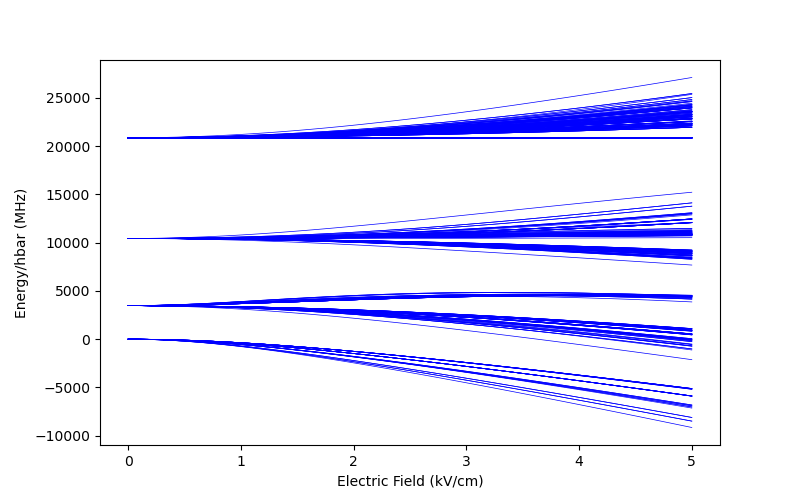

In [13]:
plt.close()

fig, ax = plt.subplots(figsize=(8, 5))
for energies in np.transpose(eigenvalues_to_plot):
    ax.plot(E_range*1e-5, energies*1e-6/h, color='b', linewidth=0.5) #, 'o', alpha = 0.5,  markersize=1)

ax.set_ylabel("Energy/hbar (MHz)")
ax.set_xlabel("Electric Field (kV/cm)")